In [2]:
# import os
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# cd '/content/drive/MyDrive/281 Project/fracture-classification'

In [4]:
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
import random
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle

In [5]:
# Define paths for each fracture type
root = '../data/'
paths = {
    'Hairline Fracture': root + 'Hairline Fracture/Train',
    'Spiral Fracture': root + 'Spiral Fracture/Train',
    'Greenstick Fracture': root + 'Greenstick fracture/Train',
    'Comminuted Fracture': root + 'Comminuted fracture/Train',
    'Fracture Dislocation': root + 'Fracture Dislocation/Train',
    'Pathological Fracture': root + 'Pathological fracture/Train',
    'Longitudinal Fracture': root + 'Longitudinal fracture/Train',
    'Oblique Fracture': root + 'Oblique fracture/Train',
    'Impacted Fracture': root + 'Impacted fracture/Train',
    'Avulsion Fracture': root + 'Avulsion fracture/Train'
}

### Process features

In [6]:
# Function to load and preprocess an image
def load_image(image_path, image_size=(512, 512)):
    # Read the image from the file
    image = tf.io.read_file(image_path)
    # Decode the JPEG image into a tensor
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize the image to the desired size
    image = tf.image.resize(image, image_size)
    # Normalize the pixel values to [0, 1]
    image = image / 255.0
    return image

# Custom feature extraction functions
def extract_hog_features(class_path, image_files):
    featurelist = []
    for image in tqdm(image_files, desc="Extracting HOG features"):
        image_path = os.path.join(class_path, image)
        image = load_image(image_path)
        image = (image * 255).numpy().astype('uint8')
        fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2), visualize=True, channel_axis=-1)
        featurelist.append(fd[np.newaxis, :])
    features = np.vstack(featurelist)
    return features, hog_image

def extract_canny_edges(class_path, image_files):
    featurelist = []
    for image in tqdm(image_files, desc="Extracting Canny edges"):
        image_path = os.path.join(class_path, image)
        image = load_image(image_path)
        image = (image * 255).numpy().astype('uint8')
        edges = cv2.Canny(image, threshold1=100, threshold2=200)
        edges_flat = edges.ravel()
        featurelist.append(edges_flat[np.newaxis, :])
    features = np.vstack(featurelist)
    return features, edges

def extract_contours(class_path, image_files):
    featurelist = []
    for image in tqdm(image_files, desc="Extracting Contours"):
        image_path = os.path.join(class_path, image)
        image = load_image(image_path)
        image = (image * 255).numpy().astype('uint8')
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contour_features = []
        for contour in contours[:5]:
            moments = cv2.moments(contour)
            hu_moments = cv2.HuMoments(moments).flatten()
            contour_features.extend(hu_moments)
        # Ensure all feature vectors are of the same length
        if len(contour_features) < 35:
            contour_features.extend([0] * (35 - len(contour_features)))
        featurelist.append(np.array(contour_features)[np.newaxis, :])
    features = np.vstack(featurelist)
    return features, contours

In [7]:
# Print label to fracture mapping
label_to_fracture = {label: fracture for label, fracture in enumerate(paths.keys())}
print("Label to Fracture Mapping:")
for label, fracture in label_to_fracture.items():
    print(f"{label}: {fracture}")

#CHANGE THIS CODE TO ACCOUNT FOR REMOVED VAL SPLIT FROM load_data.py
# y = np.load("data/images/label_ids_train.npy")
# y_val = np.load("data/images/label_ids_val.npy")
# print(y.shape)
# print(y_val.shape)
# y = np.concatenate((y, y_val))
# print(y.shape)
# for label, fracture in label_to_fracture.items():
#     print(f"{label}: {fracture}")

Label to Fracture Mapping:
0: Hairline Fracture
1: Spiral Fracture
2: Greenstick Fracture
3: Comminuted Fracture
4: Fracture Dislocation
5: Pathological Fracture
6: Longitudinal Fracture
7: Oblique Fracture
8: Impacted Fracture
9: Avulsion Fracture


### Look at explained variance for PCA

In [8]:
def normalize_features(features):
    scaler = StandardScaler()
    return scaler.fit_transform(features)

def get_PCA(X, n_components):
    pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X)
    X_pca = pca.transform(X)
    return pca, X_pca

def plot_explained_variance(pca, feature_name):
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(15, 5))
    plt.plot(explained_variance, label=f'Explained Variance ({feature_name})')
    max_ticks = 20
    if len(explained_variance) > max_ticks:
        plt.xticks(np.arange(0, len(explained_variance), len(explained_variance) // max_ticks))
    else:
        plt.xticks(np.arange(1, len(explained_variance) + 1))
    plt.yticks(np.linspace(0, 1, 8))
    plt.grid(True)
    plt.xlabel('Number of components')
    plt.ylabel('Explained Variance')
    plt.legend()
    plt.title(f'Explained Variance Plot for {feature_name}')
    plt.show()

def get_pca_data(image_path, class_name, class_path):
    # List all image files in the directory
    image_files = tf.io.gfile.listdir(class_path)
    # Extract features using the defined functions
    hog_features, hog_image = extract_hog_features(class_path, image_files)
    print("HOG Features Shape: ")
    print(hog_features.shape)
    canny_features, canny_image = extract_canny_edges(class_path, image_files)
    print("Canny Features Shape: ")
    print(canny_features.shape)
    contour_features, contours = extract_contours(class_path, image_files)
    print("Contour Features Shape: ")
    print(contour_features.shape)

    # Normalize features
    hog_features_normalized = normalize_features(hog_features)
    canny_features_normalized = normalize_features(canny_features)
    contour_features_normalized = normalize_features(contour_features)

    # Plot PCA explained variance
    print("Plotting PCA explained variance")
    pca_hog, _ = get_PCA(hog_features_normalized, n_components=min(hog_features_normalized.shape))
    plot_explained_variance(pca_hog, f'{class_name} - HOG')
    
    pca_canny, _ = get_PCA(canny_features_normalized, n_components=min(canny_features_normalized.shape))
    plot_explained_variance(pca_canny, f'{class_name} - Canny')
    
    pca_contour, _ = get_PCA(contour_features_normalized, n_components=min(contour_features_normalized.shape))
    plot_explained_variance(pca_contour, f'{class_name} - Contour')

    return hog_features_normalized, canny_features_normalized, contour_features_normalized


Run batches due to kernel / memory limitations

Hairline Fracture


Extracting HOG features: 100%|███████████████████████████████████████████████████████| 101/101 [00:53<00:00,  1.88it/s]


HOG Features Shape: 
(101, 142884)


Extracting Canny edges: 100%|███████████████████████████████████████████████████████| 101/101 [00:00<00:00, 132.20it/s]


Canny Features Shape: 
(101, 262144)


Extracting Contours: 100%|██████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 134.67it/s]


Contour Features Shape: 
(101, 35)
Plotting PCA explained variance


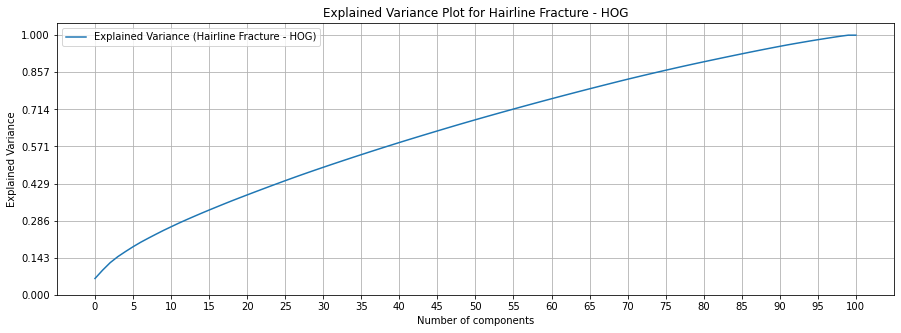

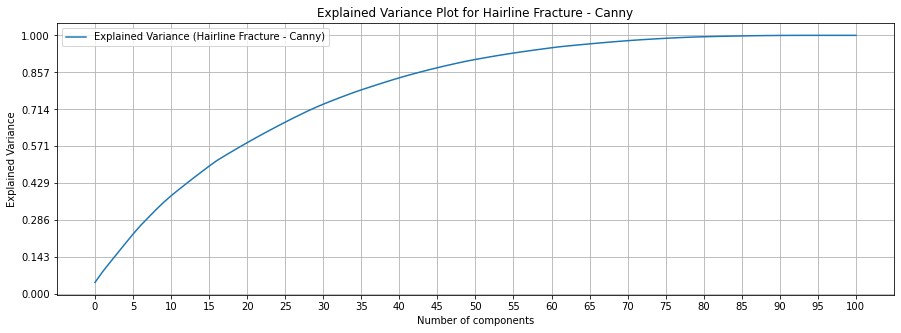

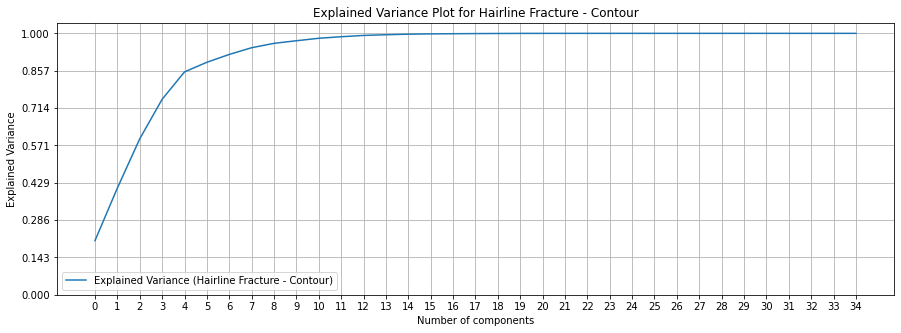

Spiral Fracture


Extracting HOG features: 100%|█████████████████████████████████████████████████████████| 74/74 [00:39<00:00,  1.88it/s]


HOG Features Shape: 
(74, 142884)


Extracting Canny edges: 100%|█████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 126.71it/s]


Canny Features Shape: 
(74, 262144)


Extracting Contours: 100%|████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 126.71it/s]


Contour Features Shape: 
(74, 35)
Plotting PCA explained variance


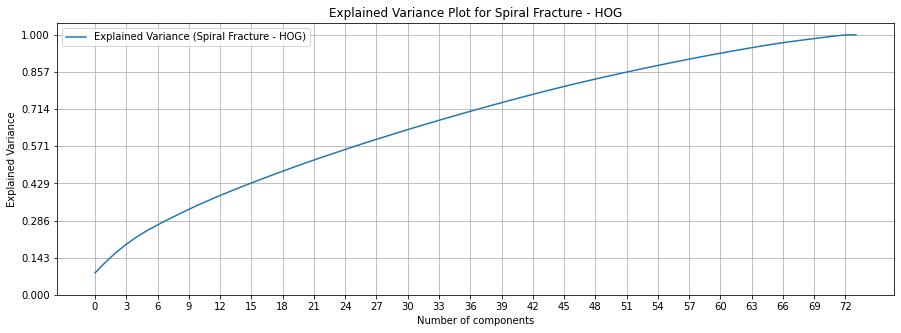

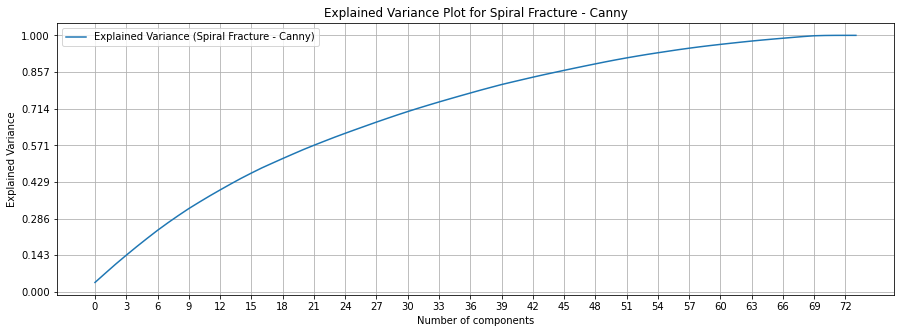

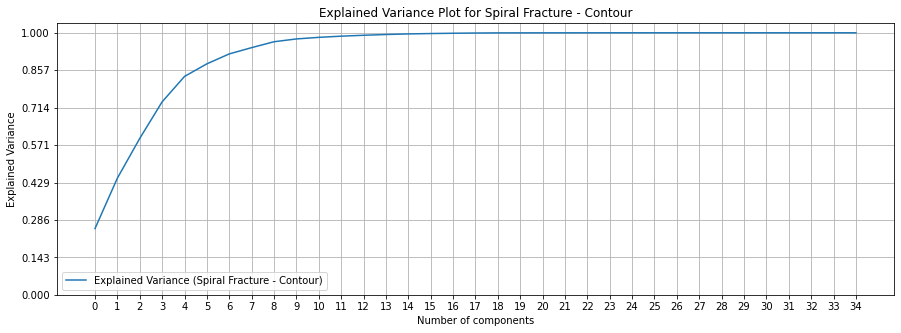

Greenstick Fracture


Extracting HOG features: 100%|███████████████████████████████████████████████████████| 106/106 [00:56<00:00,  1.88it/s]


HOG Features Shape: 
(106, 142884)


Extracting Canny edges: 100%|███████████████████████████████████████████████████████| 106/106 [00:00<00:00, 134.01it/s]


Canny Features Shape: 
(106, 262144)


Extracting Contours: 100%|██████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 134.52it/s]


Contour Features Shape: 
(106, 35)
Plotting PCA explained variance


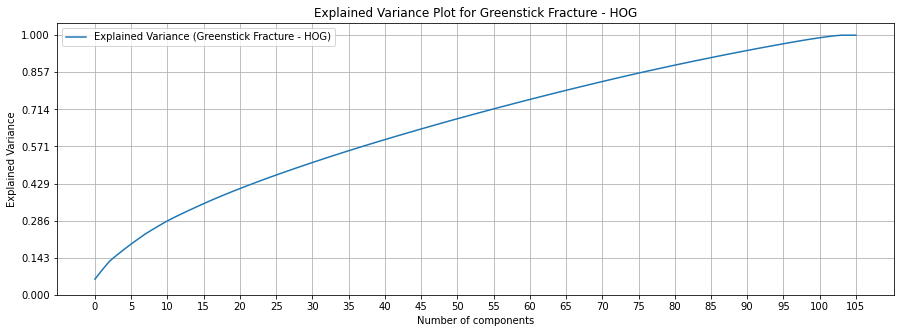

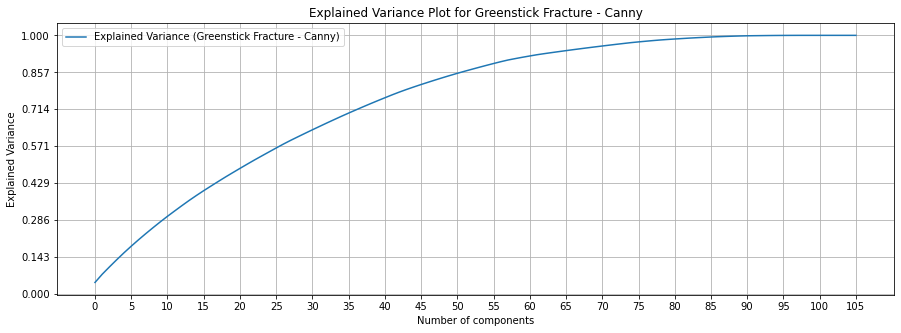

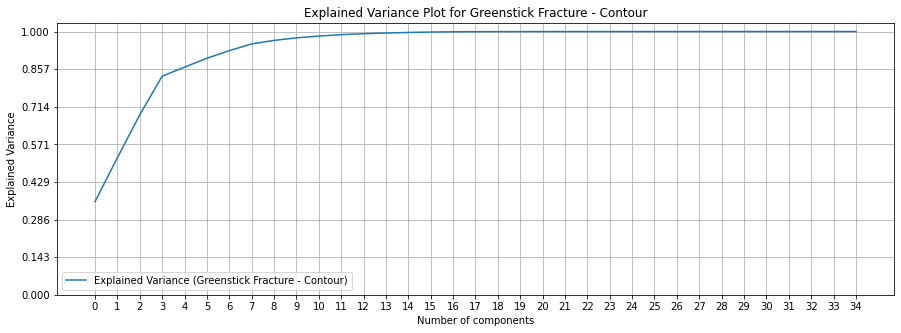

In [9]:
# Process Batch 1
batch_1 = list(paths.items())[:3]

all_hog_features_1 = np.empty((0, 142884))
all_canny_features_1 = np.empty((0, 262144))
all_contour_features_1 = np.empty((0, 35))

for class_name, class_path in batch_1:
    print(class_name)
    hog_features, canny_features, contour_features = get_pca_data(class_path, class_name, class_path)
    all_hog_features_1 = np.vstack((all_hog_features_1, hog_features))
    all_canny_features_1 = np.vstack((all_canny_features_1, canny_features))
    all_contour_features_1 = np.vstack((all_contour_features_1, contour_features))

with open('pkl/all_hog_features_1.pkl', 'wb') as f:
    pickle.dump(all_hog_features_1, f)

with open('pkl/all_canny_features_1.pkl', 'wb') as f:
    pickle.dump(all_canny_features_1, f)

with open('pkl/all_contour_features_1.pkl', 'wb') as f:
    pickle.dump(all_contour_features_1, f)

# Reset arrays to save memory
del all_hog_features_1
del all_canny_features_1
del all_contour_features_1

# Hairline 70, 40, 10
# Spiral 51, 42, 10
# Greenstick 75, 50, 10

Comminuted Fracture


Extracting HOG features: 100%|███████████████████████████████████████████████████████| 134/134 [01:10<00:00,  1.90it/s]


HOG Features Shape: 
(134, 142884)


Extracting Canny edges: 100%|███████████████████████████████████████████████████████| 134/134 [00:00<00:00, 138.86it/s]


Canny Features Shape: 
(134, 262144)


Extracting Contours: 100%|██████████████████████████████████████████████████████████| 134/134 [00:01<00:00, 131.89it/s]


Contour Features Shape: 
(134, 35)
Plotting PCA explained variance


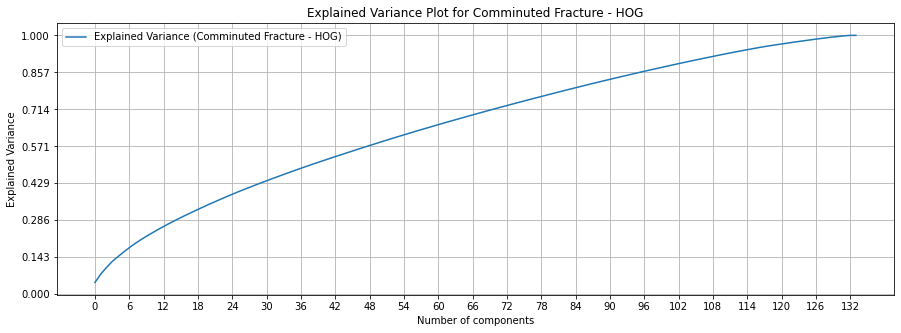

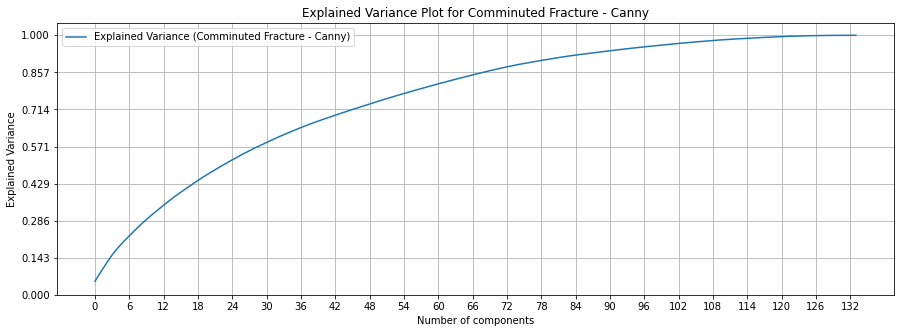

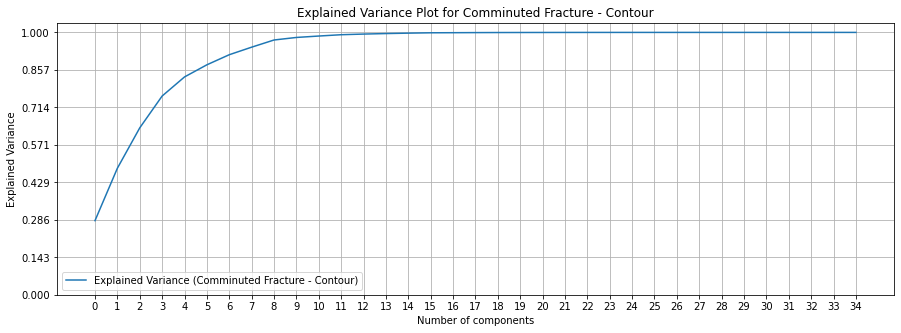

Fracture Dislocation


Extracting HOG features: 100%|███████████████████████████████████████████████████████| 137/137 [01:13<00:00,  1.86it/s]


HOG Features Shape: 
(137, 142884)


Extracting Canny edges: 100%|███████████████████████████████████████████████████████| 137/137 [00:00<00:00, 142.56it/s]


Canny Features Shape: 
(137, 262144)


Extracting Contours: 100%|██████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 148.79it/s]


Contour Features Shape: 
(137, 35)
Plotting PCA explained variance


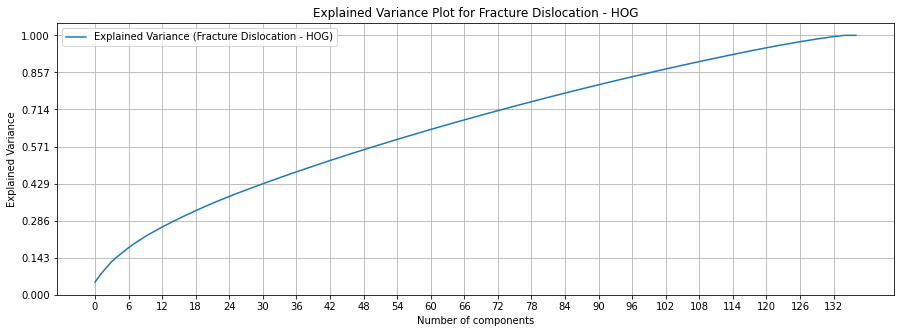

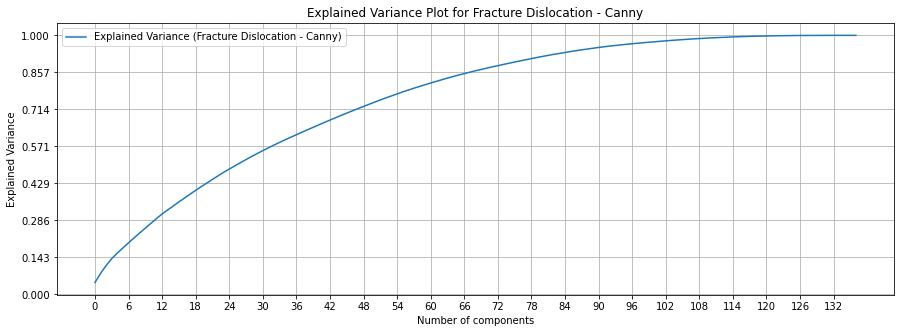

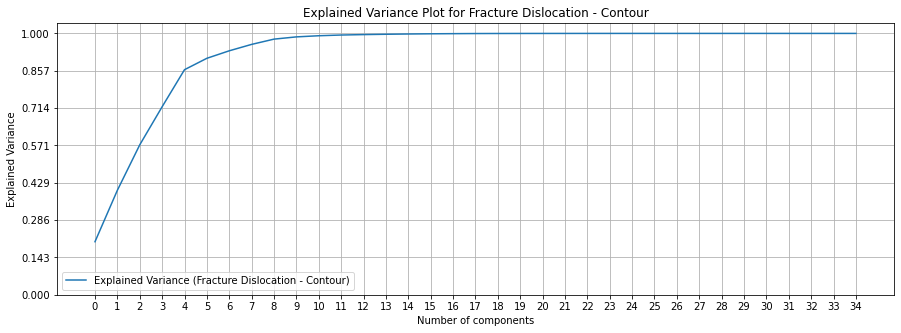

Pathological Fracture


Extracting HOG features: 100%|███████████████████████████████████████████████████████| 116/116 [01:02<00:00,  1.86it/s]


HOG Features Shape: 
(116, 142884)


Extracting Canny edges: 100%|███████████████████████████████████████████████████████| 116/116 [00:00<00:00, 130.78it/s]


Canny Features Shape: 
(116, 262144)


Extracting Contours: 100%|██████████████████████████████████████████████████████████| 116/116 [00:00<00:00, 130.04it/s]


Contour Features Shape: 
(116, 35)
Plotting PCA explained variance


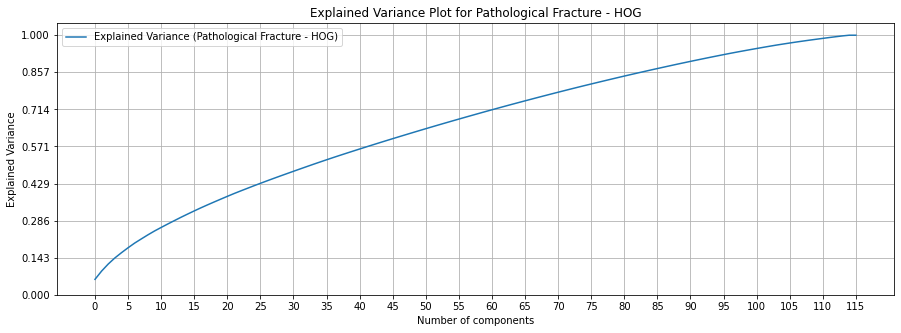

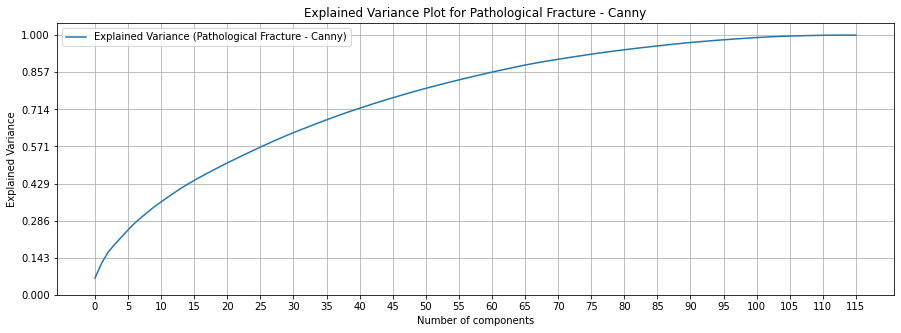

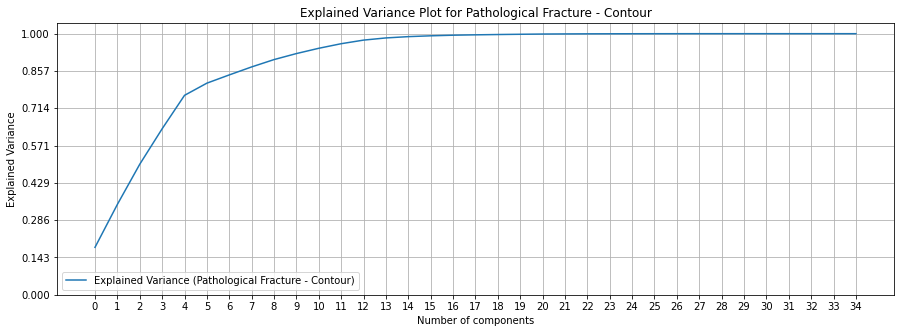

In [10]:
# Process Batch 2
batch_2 = list(paths.items())[3:6]

all_hog_features_2 = np.empty((0, 142884))
all_canny_features_2 = np.empty((0, 262144))
all_contour_features_2 = np.empty((0, 35))

for class_name, class_path in batch_2:
    print(class_name)
    hog_features, canny_features, contour_features = get_pca_data(class_path, class_name, class_path)
    all_hog_features_2 = np.vstack((all_hog_features_2, hog_features))
    all_canny_features_2 = np.vstack((all_canny_features_2, canny_features))
    all_contour_features_2 = np.vstack((all_contour_features_2, contour_features))

with open('pkl/all_hog_features_2.pkl', 'wb') as f:
    pickle.dump(all_hog_features_2, f)

with open('pkl/all_canny_features_2.pkl', 'wb') as f:
    pickle.dump(all_canny_features_2, f)

with open('pkl/all_contour_features_2.pkl', 'wb') as f:
    pickle.dump(all_contour_features_2, f)

# Reset arrays to save memory
del all_hog_features_2
del all_canny_features_2
del all_contour_features_2

# Comminuted 96, 66, 10
# Dislocation 96, 66, 10
# Pathological 80, 60, 10

Longitudinal Fracture


Extracting HOG features: 100%|█████████████████████████████████████████████████████████| 68/68 [00:36<00:00,  1.88it/s]


HOG Features Shape: 
(68, 142884)


Extracting Canny edges: 100%|█████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 141.08it/s]


Canny Features Shape: 
(68, 262144)


Extracting Contours: 100%|████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 146.55it/s]


Contour Features Shape: 
(68, 35)
Plotting PCA explained variance


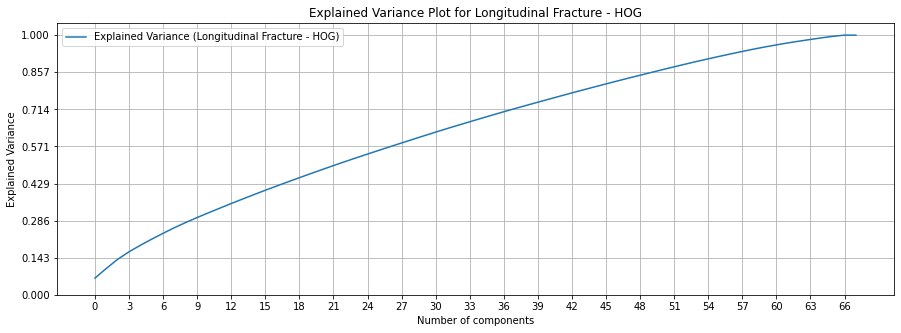

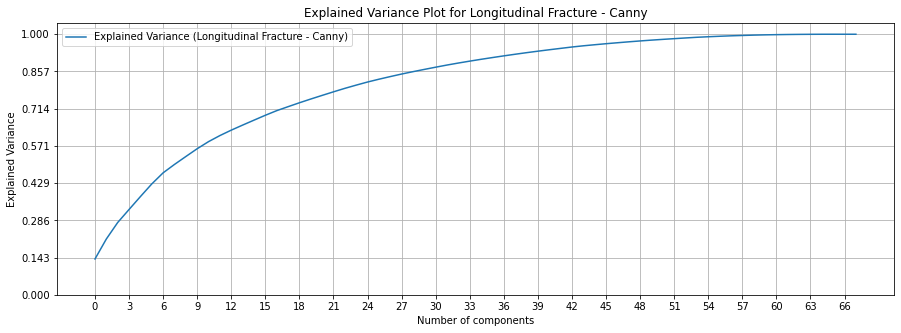

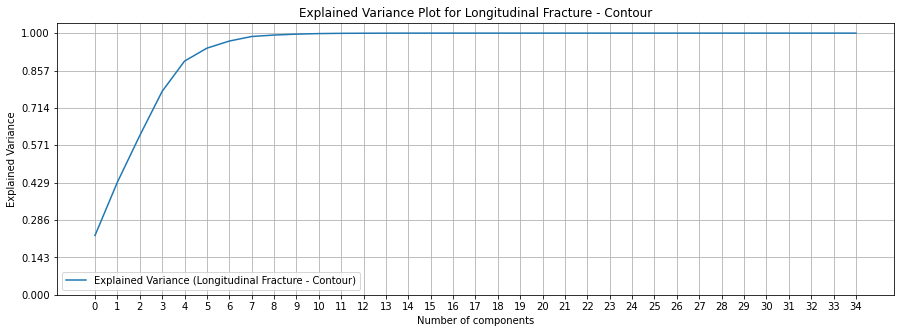

Oblique Fracture


Extracting HOG features: 100%|█████████████████████████████████████████████████████████| 69/69 [00:36<00:00,  1.89it/s]


HOG Features Shape: 
(69, 142884)


Extracting Canny edges: 100%|█████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 141.68it/s]


Canny Features Shape: 
(69, 262144)


Extracting Contours: 100%|████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 147.44it/s]


Contour Features Shape: 
(69, 35)
Plotting PCA explained variance


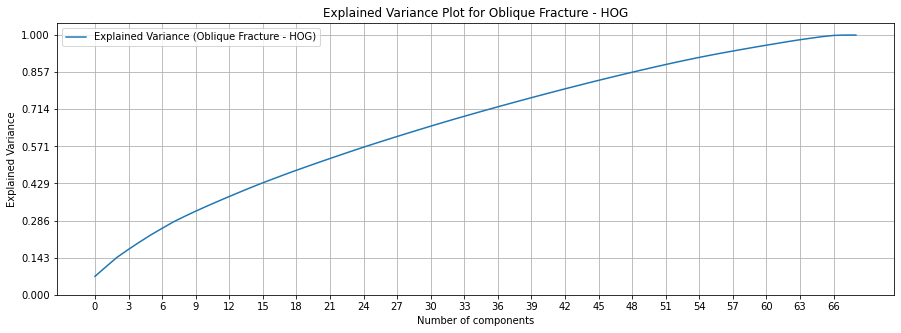

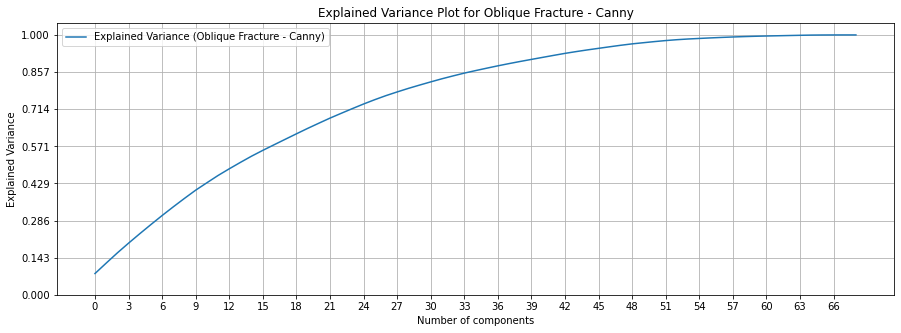

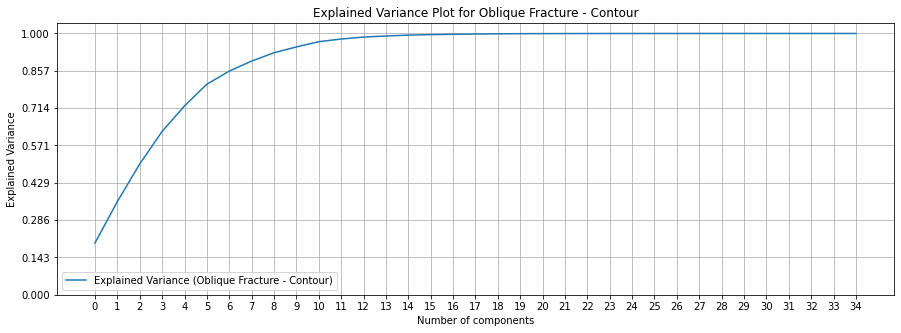

In [11]:
# Process Batch 3
batch_3 = list(paths.items())[6:8]

all_hog_features_3 = np.empty((0, 142884))
all_canny_features_3 = np.empty((0, 262144))
all_contour_features_3 = np.empty((0, 35))

for class_name, class_path in batch_3:
    print(class_name)
    hog_features, canny_features, contour_features = get_pca_data(class_path, class_name, class_path)
    all_hog_features_3 = np.vstack((all_hog_features_3, hog_features))
    all_canny_features_3 = np.vstack((all_canny_features_3, canny_features))
    all_contour_features_3 = np.vstack((all_contour_features_3, contour_features))

with open('pkl/all_hog_features_3.pkl', 'wb') as f:
    pickle.dump(all_hog_features_3, f)

with open('pkl/all_canny_features_3.pkl', 'wb') as f:
    pickle.dump(all_canny_features_3, f)

with open('pkl/all_contour_features_3.pkl', 'wb') as f:
    pickle.dump(all_contour_features_3, f)

# Reset arrays to save memory
del all_hog_features_3
del all_canny_features_3
del all_contour_features_3

# Longitudinal 48, 27, 10
# Oblique 48, 33, 10

Impacted Fracture


Extracting HOG features: 100%|█████████████████████████████████████████████████████████| 75/75 [00:39<00:00,  1.88it/s]


HOG Features Shape: 
(75, 142884)


Extracting Canny edges: 100%|█████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 140.71it/s]


Canny Features Shape: 
(75, 262144)


Extracting Contours: 100%|████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 143.68it/s]


Contour Features Shape: 
(75, 35)
Plotting PCA explained variance


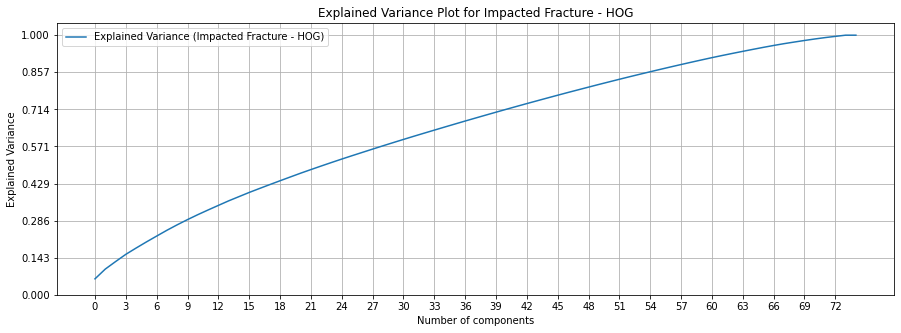

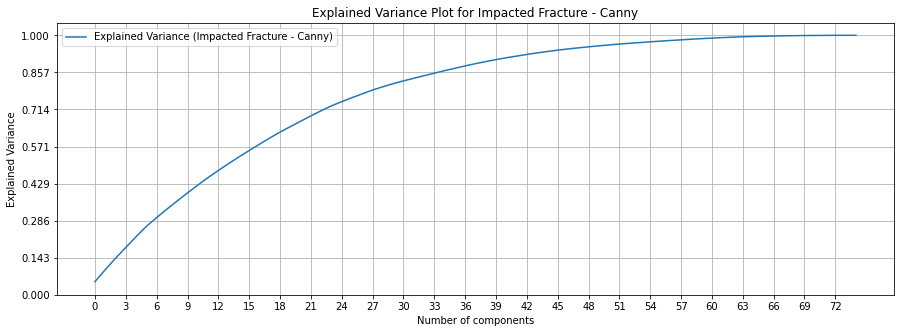

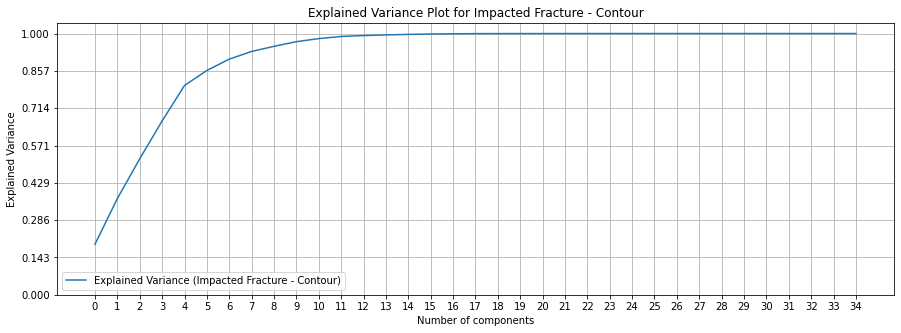

Avulsion Fracture


Extracting HOG features: 100%|███████████████████████████████████████████████████████| 109/109 [00:57<00:00,  1.89it/s]


HOG Features Shape: 
(109, 142884)


Extracting Canny edges: 100%|███████████████████████████████████████████████████████| 109/109 [00:00<00:00, 140.28it/s]


Canny Features Shape: 
(109, 262144)


Extracting Contours: 100%|██████████████████████████████████████████████████████████| 109/109 [00:00<00:00, 146.31it/s]


Contour Features Shape: 
(109, 35)
Plotting PCA explained variance


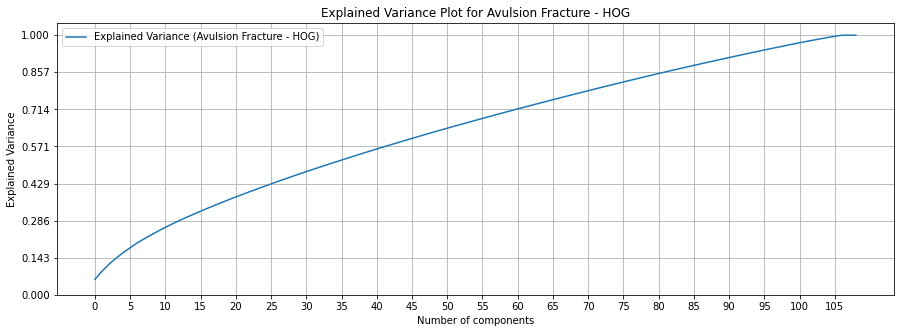

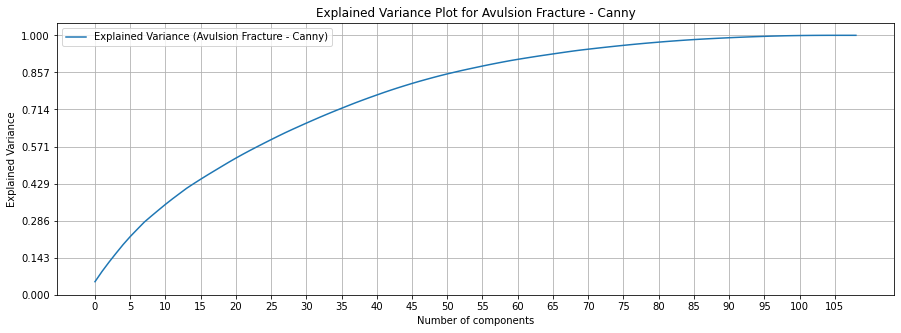

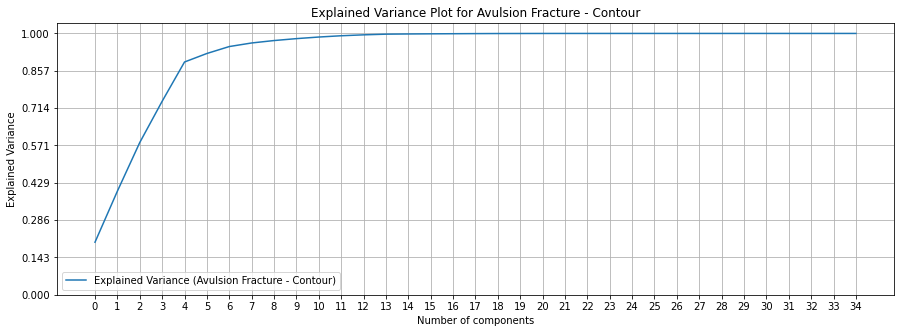

In [12]:
# Process Batch 4
batch_4 = list(paths.items())[8:]

all_hog_features_4 = np.empty((0, 142884))
all_canny_features_4 = np.empty((0, 262144))
all_contour_features_4 = np.empty((0, 35))

for class_name, class_path in batch_4:
    print(class_name)
    hog_features, canny_features, contour_features = get_pca_data(class_path, class_name, class_path)
    all_hog_features_4 = np.vstack((all_hog_features_4, hog_features))
    all_canny_features_4 = np.vstack((all_canny_features_4, canny_features))
    all_contour_features_4 = np.vstack((all_contour_features_4, contour_features))

with open('pkl/all_hog_features_4.pkl', 'wb') as f:
    pickle.dump(all_hog_features_4, f)

with open('pkl/all_canny_features_4.pkl', 'wb') as f:
    pickle.dump(all_canny_features_4, f)

with open('pkl/all_contour_features_4.pkl', 'wb') as f:
    pickle.dump(all_contour_features_4, f)

# Reset arrays to save memory
del all_hog_features_4
del all_canny_features_4
del all_contour_features_4

# Impacted 54, 33, 10
# Avulsion 80, 50, 10

In [13]:
# Combine all batches
all_hog_features_combined = np.empty((0, 142884))
all_canny_features_combined = np.empty((0, 262144))
all_contour_features_combined = np.empty((0, 35))

for suffix in [1, 2, 3, 4]:
    with open(f'pkl/all_hog_features_{suffix}.pkl', 'rb') as f:
        all_hog_features_batch = pickle.load(f)
        all_hog_features_combined = np.vstack((all_hog_features_combined, all_hog_features_batch))
    
    with open(f'pkl/all_canny_features_{suffix}.pkl', 'rb') as f:
        all_canny_features_batch = pickle.load(f)
        all_canny_features_combined = np.vstack((all_canny_features_combined, all_canny_features_batch))
    
    with open(f'pkl/all_contour_features_{suffix}.pkl', 'rb') as f:
        all_contour_features_batch = pickle.load(f)
        all_contour_features_combined = np.vstack((all_contour_features_combined, all_contour_features_batch))

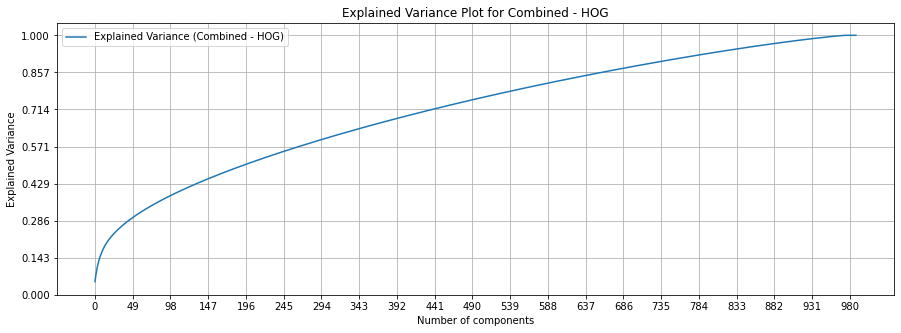

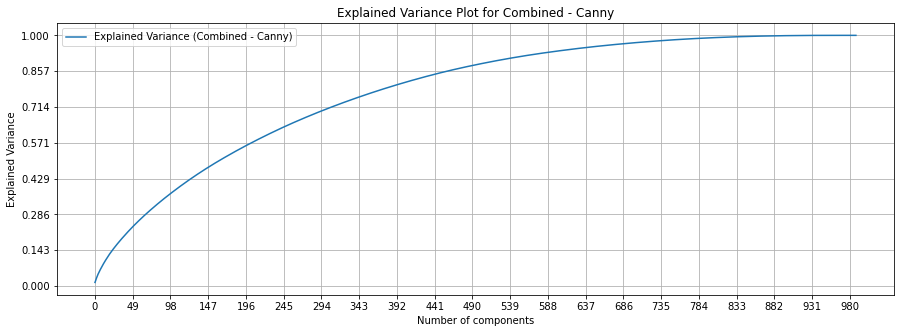

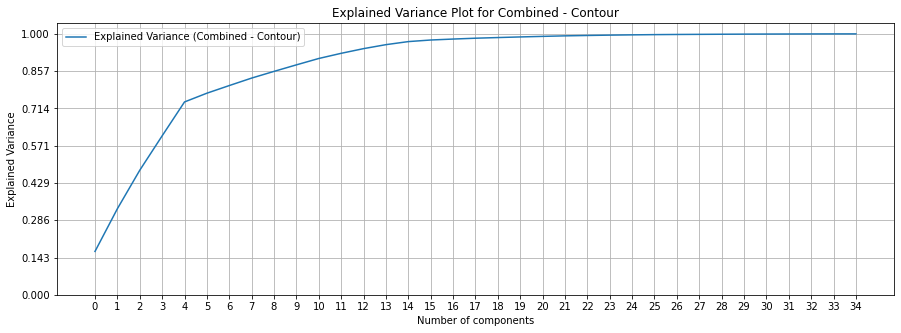

In [14]:
# Run PCA and plot explained variance on combined features
pca_hog, hog_pca_components = get_PCA(all_hog_features_combined, n_components=min(all_hog_features_combined.shape))
plot_explained_variance(pca_hog, 'Combined - HOG')

pca_canny, canny_pca_components = get_PCA(all_canny_features_combined, n_components=min(all_canny_features_combined.shape))
plot_explained_variance(pca_canny, 'Combined - Canny')

pca_contour, contour_pca_components = get_PCA(all_contour_features_combined, n_components=min(all_contour_features_combined.shape))
plot_explained_variance(pca_contour, 'Combined - Contour')

### Plot 2d plots of PCA and TSNE

In [17]:
def plot_classes(X, y, ax, title):
    # Color code each cluster (person ID)
    colormap = plt.cm.tab20
    colorst = [colormap(i) for i in np.linspace(0, 1.0, len(np.unique(y)))]

    # Project the features into 2 dimensions
    for k in range(len(np.unique(y))):
        ax.scatter(X[y==k, 0], X[y==k, 1], alpha=0.5, facecolors=colorst[k])

    ax.set_title(title)

def get_TSNE(X, n_components=2):
    tsne = TSNE(n_components=n_components, random_state=0)
    X_tsne = tsne.fit_transform(X)
    return tsne, X_tsne

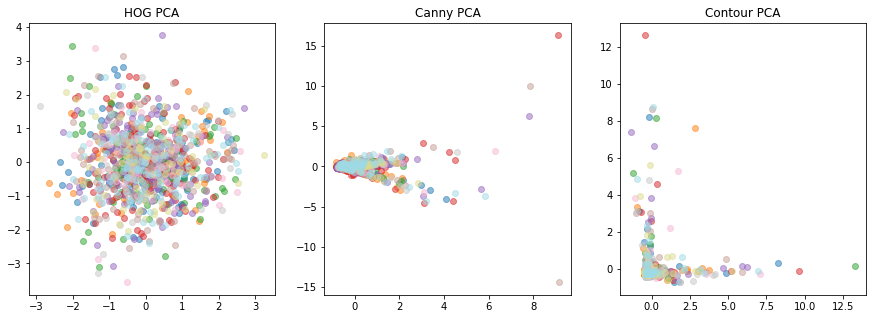

In [18]:
# Create the y array for class labels
y = np.concatenate([np.full(len(tf.io.gfile.listdir(paths[class_name])), i) for i, class_name in enumerate(paths.keys())])

# Plotting the first 2 principal components for each feature type
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

plot_classes(hog_pca_components, y, ax[0], 'HOG PCA')
plot_classes(canny_pca_components, y, ax[1], 'Canny PCA')
plot_classes(contour_pca_components, y, ax[2], 'Contour PCA')

plt.show()

HOG: The points are spread out in a more circular shape, suggesting that the first two principal components capture some variance but not enough to clearly separate the classes.

Canny: The points are more elongated along one principal component, indicating that most of the variance is captured along one direction.

Contour: The points are clustered more tightly along one axis, with a sharp drop-off. This indicates that the first principal component captures most of the variance, but it does not provide enough distinction between the classes.


C:\Users\brian\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\brian\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\brian\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\brian\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\brian\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\brian\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: Future

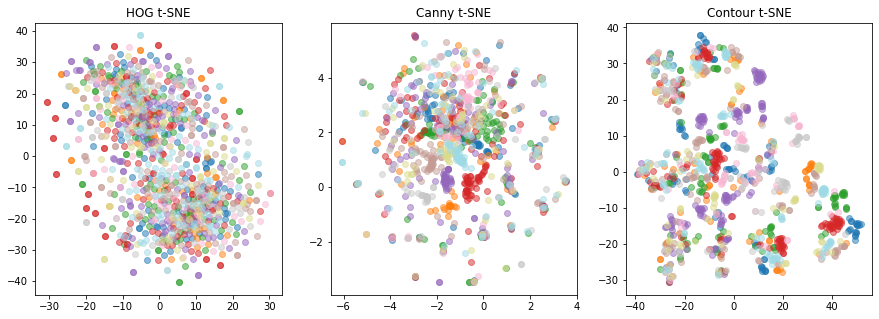

In [19]:
# Perform t-SNE on combined features
_, hog_tsne_components = get_TSNE(all_hog_features_combined, n_components=2)
_, canny_tsne_components = get_TSNE(all_canny_features_combined, n_components=2)
_, contour_tsne_components = get_TSNE(all_contour_features_combined, n_components=2)

# Create a new figure for t-SNE plots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

plot_classes(hog_tsne_components, y, ax[0], 'HOG t-SNE')
plot_classes(canny_tsne_components, y, ax[1], 'Canny t-SNE')
plot_classes(contour_tsne_components, y, ax[2], 'Contour t-SNE')

plt.show()